In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
from pykalman import KalmanFilter

In [7]:
cpu_data = pd.read_csv('sysinfo.csv')
cpu_data.head()

,cpu_percent,temperature,timestamp
0,0.38,34,2017-05-24 18:41:53.875155
1,0.86,35,2017-05-24 18:42:53.879360
2,0.12,34,2017-05-24 18:43:53.883331
3,0.97,34,2017-05-24 18:44:53.887442
4,0.38,34,2017-05-24 18:45:53.891643


Use the **lowess** function from statsmodels to generated a smoothed version of the temperature values.

Adjust the frac parameter to get as much signal as possible with as little noise as possible. The contrasting factors: 
* (1) when the temperature spikes (because of momentary CPU usage), the high temperature values are reality and we don't want to smooth that information out of existence, but 
* (2) when the temperature is relatively flat (where the computer is not in use), the temperature is probably relatively steady, not jumping randomly between 30°C and 33°C as the data implies.

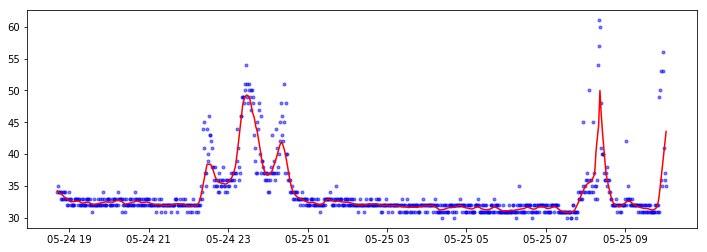

In [8]:
cpu_data['timestamp'] = pd.to_datetime(cpu_data['timestamp'])
plt.figure(figsize=(12, 4))
plt.plot(cpu_data['timestamp'], cpu_data['temperature'], 'b.', alpha=0.5)
#Loess_smooth: 
loess_smoothed = lowess(cpu_data['temperature'], cpu_data['timestamp'], 
                        frac = 0.02)
plt.plot(cpu_data['timestamp'], loess_smoothed[:, 1], 'r-')

**Kalman filter** will let us take more information into account: we can use the processor usage and system load to give a hint about when the temperature will be increasing/decreasing. The time stamp will be distracting: keep only the three columns you need.

Choose sensible (non-zero) values for the observation standard deviations here. 

* The value observation_covariance expresses how much you believe the sensors: what kind of error do you usually expect to see (perhaps based on looking at the scatter plot, or by estimating the accuracy of the observed values). 
* The values in the template above are taken to be standard deviations (in the same units as the corresponding values) and then squared to give variance values that the filter expects.
* The transition_covariance expresses how accurate your prediction is: how accurately can you predict the temperature of the CPU (and processor percent/load), based on the previous temperature and processor usage?
* The transition matrix is where we can be more clever. I predict that the “next” values of the variables we're observing will be:
temperature←1.0×temperature−0.27×sys_load_1cpu_percent←0.85×cpu_percent−1.14×sys_load_1sys_load_1←0.06×cpu_percent+0.37×sys_load_1
These values are the result of doing some regression on the values. 

Experiment with the parameter values to get the best smoothed result. The tradeoffs are the same as before: removing noise while keeping true changes in the signal.

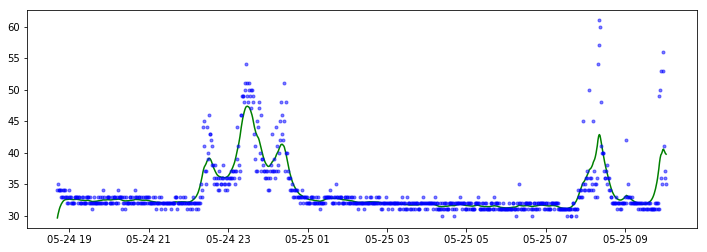

In [9]:
#Kalman_smooth
kalman_data = cpu_data[['temperature', 'cpu_percent']]
initial_state = kalman_data.iloc[0]
initial = np.array(initial_state)
observation_covariance = [[1 ** 2, 0], [0, 2 ** 2]]
transition_covariance = [[0.15 ** 2, 0], [0, 80 ** 2]]
initial_state_covariance = observation_covariance
transition_matrices = [[1, 0], [0.125, 1]]


kf = KalmanFilter(initial_state_covariance, 
                  observation_covariance,
                  transition_covariance,
                  transition_matrices
)
kalman_smoothed, _ = kf.smooth(kalman_data)
plt.figure(figsize=(12, 4))
plt.plot(cpu_data['timestamp'], kalman_smoothed[:, 0], 'g-')
plt.plot(cpu_data['timestamp'], cpu_data['temperature'], 'b.', alpha=0.5)

plt.show()